Step 1: Generate Synthetic Data
We create synthetic temperature and rainfall data, along with seasonal labels (0: Winter, 1: Spring, 2: Summer, 3: Autumn).

In [1]:
import numpy as np

# Generate synthetic data
num_years = 10  # 10 years of data
time = np.arange(num_years * 12) / 12.0  # Monthly timestamps

# Temperature (sinusoidal with noise)
temperature = 10 * np.sin(2 * np.pi * time) + 20 + np.random.normal(0, 2, len(time))

# Rainfall (higher in spring)
rainfall = np.where((time % 1 >= 0.25) & (time % 1 < 0.5),
                    100 + np.random.normal(0, 10, len(time)),
                    50 + np.random.normal(0, 10, len(time)))

# Assign seasons (Northern Hemisphere)
seasons = []
for month in range(len(time)):
    if (month % 12) < 3 or (month % 12) == 11:
        seasons.append(0)  # Winter
    elif (month % 12) < 6:
        seasons.append(1)  # Spring
    elif (month % 12) < 9:
        seasons.append(2)  # Summer
    else:
        seasons.append(3)  # Autumn

features = np.column_stack((temperature, rainfall))
seasons = np.array(seasons)

Step 2: Preprocess Data
Structure sequences of 12 months to predict the next 6 months' seasons.

In [2]:
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

look_back = 12  # Use 12 months to predict
output_length = 6  # Predict 6 months ahead

# Create input-output sequences
X, y = [], []
for i in range(len(features) - look_back - output_length + 1):
    X.append(features[i:i+look_back])
    y.append(seasons[i+look_back:i+look_back+output_length])

X = np.array(X)
y = np.array(y)

# One-hot encode labels
y_onehot = to_categorical(y, num_classes=4)

# Normalize features
scaler = StandardScaler()
X_reshaped = X.reshape(-1, 2)
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)

# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_onehot[:split], y_onehot[split:]

Step 3: Build the LSTM Model
A simple LSTM model predicting 6 months of seasonal labels.

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape, Activation

model = Sequential()
model.add(LSTM(64, input_shape=(look_back, 2)))  # Input: (12 months, 2 features)
model.add(Dense(6 * 4))  # Output: 6 months × 4 seasons
model.add(Reshape((6, 4)))  # Reshape to (6, 4)
model.add(Activation("softmax"))  # Softmax for classification

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 6, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 6, 4)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,712 (73.09 KB)

 Trainable params: 18,712 (73.09 KB)

 Non-trainable params: 0 (0.00 B)

Step 4: Train the Model

In [4]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.2450 - loss: 1.3878 - val_accuracy: 0.4127 - val_loss: 1.3677
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3626 - loss: 1.3712 - val_accuracy: 0.5079 - val_loss: 1.3520
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4964 - loss: 1.3533 - val_accuracy: 0.6270 - val_loss: 1.3361
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5924 - loss: 1.3375 - val_accuracy: 0.6270 - val_loss: 1.3192
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6441 - loss: 1.3210 - val_accuracy: 0.6825 - val_loss: 1.3005
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6683 - loss: 1.2998 - val_accuracy: 0.6984 - val_loss: 1.2786
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7064 - loss: 1.2756 - val_accuracy: 0.7063 - val_loss: 1.2522
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7293 - loss: 1.2465 - val_accuracy: 0.7460 - val_loss: 1.2192

Step 5: Predict Seasons for 6 Months

In [5]:
sample_input = X_test[0]  # Example input (12 months of data)
prediction = model.predict(sample_input[np.newaxis, ...])
predicted_seasons = np.argmax(prediction, axis=-1).flatten()

# Map indices to seasons
season_map = {0: "Winter", 1: "Spring", 2: "Summer", 3: "Autumn"}
predicted_seasons = [season_map[idx] for idx in predicted_seasons]

print("Predicted seasons:", predicted_seasons)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predicted seasons: ['Autumn', 'Winter', 'Winter', 'Winter', 'Winter', 'Spring']


Plot Synthetic Data Patterns

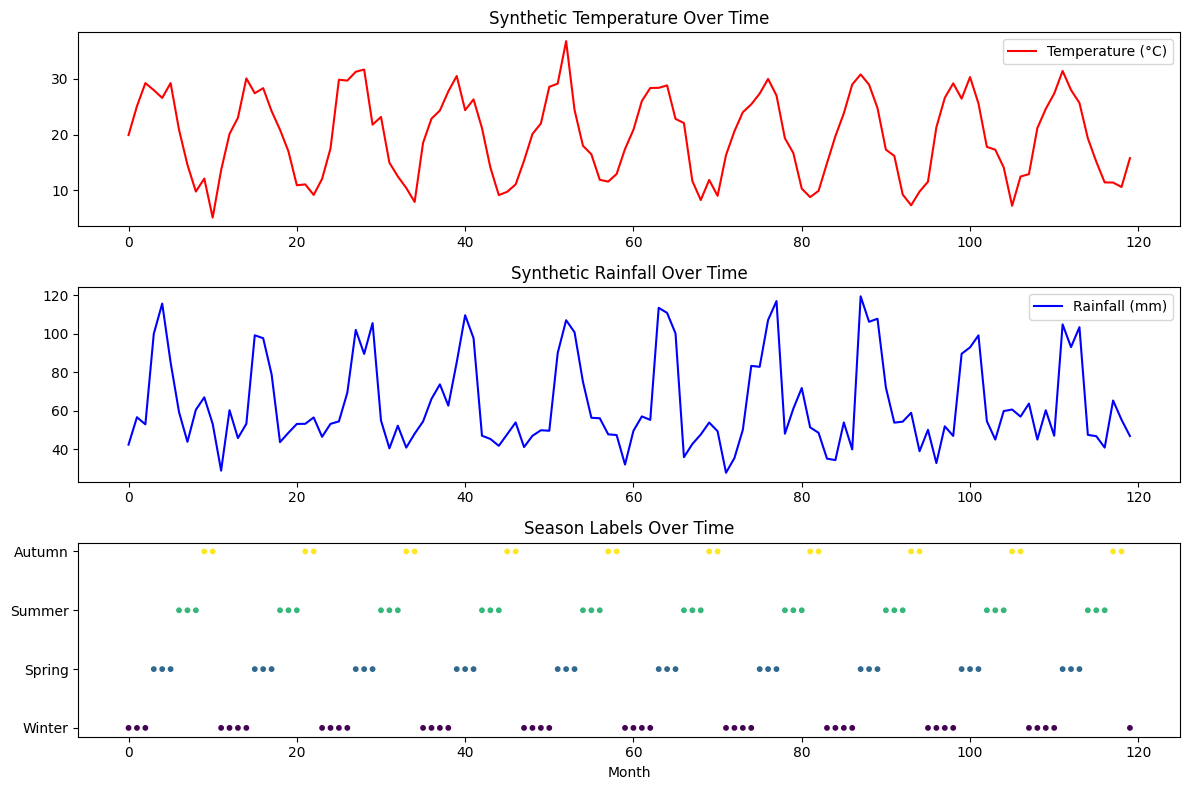

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(temperature, label='Temperature (°C)', color='red')
plt.title("Synthetic Temperature Over Time")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(rainfall, label='Rainfall (mm)', color='blue')
plt.title("Synthetic Rainfall Over Time")
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(range(len(seasons)), seasons, c=seasons, cmap='viridis', s=10)
plt.yticks([0, 1, 2, 3], ['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title("Season Labels Over Time")
plt.xlabel("Month")

plt.tight_layout()
plt.savefig("synthetic_data.png", dpi=300)
plt.show()

Plot Training History

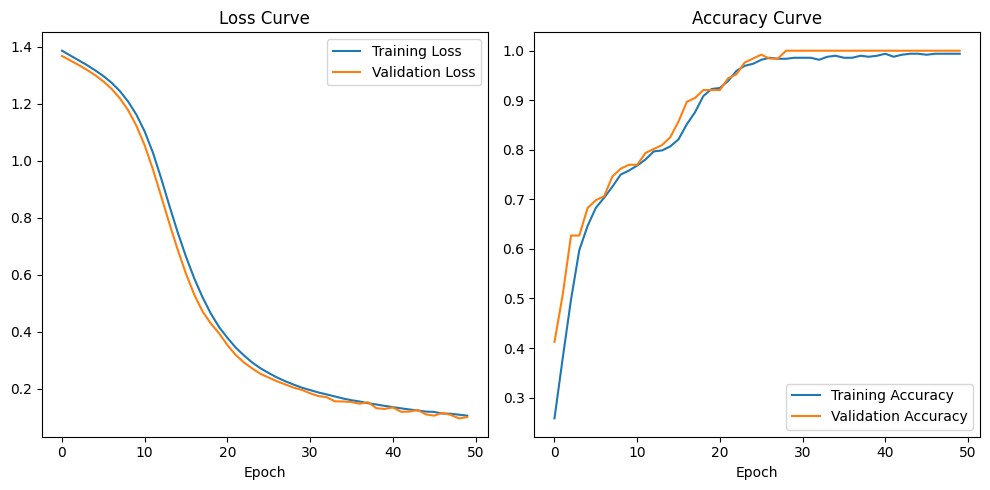

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.savefig("training_history.png", dpi=300)
plt.show()

Visualize Predictions vs. Ground Truth

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


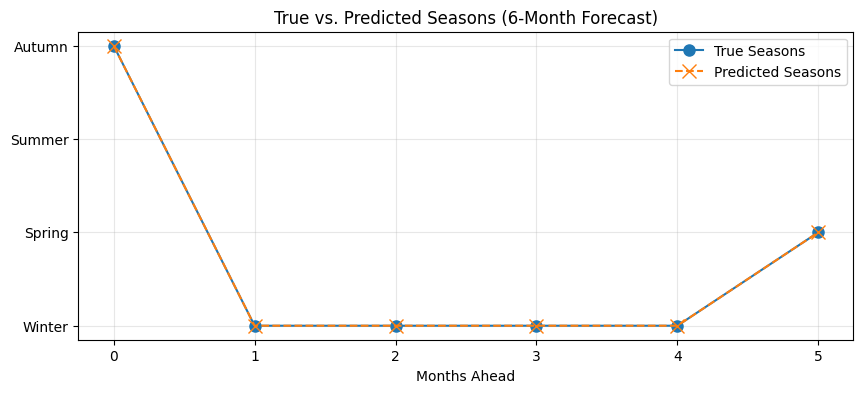

In [8]:
# Get a test sample and its prediction
sample_idx = 0
sample_X = X_test[sample_idx]
sample_y = y_test[sample_idx]
prediction = model.predict(sample_X[np.newaxis, ...])
predicted_seasons = np.argmax(prediction, axis=-1).flatten()
true_seasons = np.argmax(sample_y, axis=-1).flatten()

# Plot
months = np.arange(6)
season_names = ['Winter', 'Spring', 'Summer', 'Autumn']

plt.figure(figsize=(10, 4))
plt.plot(months, true_seasons, 'o-', label='True Seasons', markersize=8)
plt.plot(months, predicted_seasons, 'x--', label='Predicted Seasons', markersize=10)
plt.yticks([0, 1, 2, 3], season_names)
plt.xlabel("Months Ahead")
plt.title("True vs. Predicted Seasons (6-Month Forecast)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("prediction_vs_truth.png", dpi=300)
plt.show()

Confusion Matrix for All Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


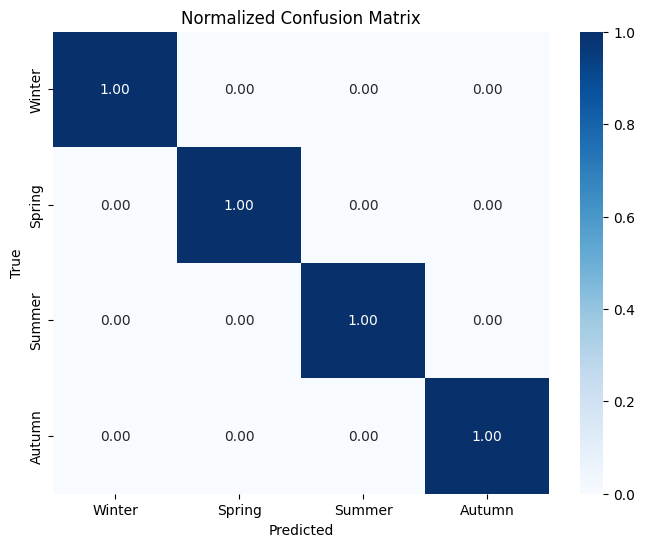

In [9]:
from sklearn.metrics import confusion_matrix

# Flatten predictions and labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred.reshape(-1, 4), axis=1)
y_true_classes = np.argmax(y_test.reshape(-1, 4), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=season_names, yticklabels=season_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

Attention to Season Transitions

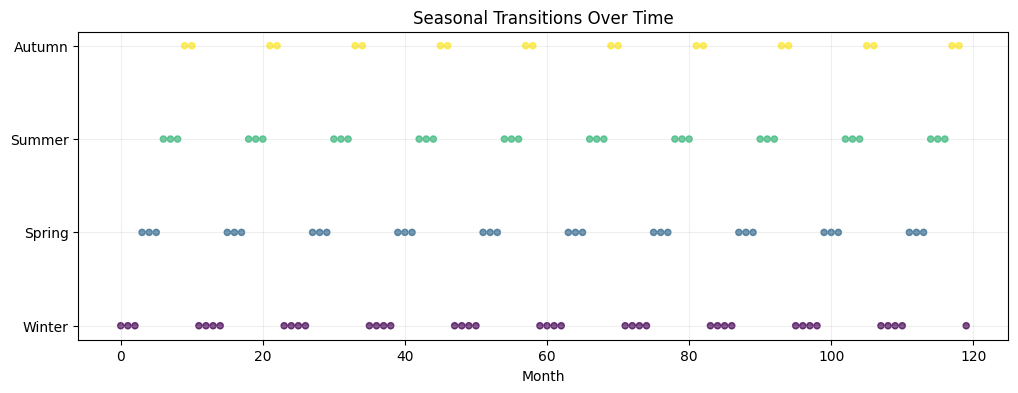

In [10]:
plt.figure(figsize=(12, 4))
plt.scatter(range(len(seasons)), seasons, c=seasons, cmap='viridis', s=20, alpha=0.7)
plt.yticks([0, 1, 2, 3], season_names)
plt.title("Seasonal Transitions Over Time")
plt.xlabel("Month")
plt.grid(alpha=0.2)
plt.savefig("season_transitions.png", dpi=300)
plt.show()